In [73]:
!pip install fractal-defi

#ETH, DOGE, PEPE and etc. funding rate analyze

В качестве анализа мы берем приведенное скользящее среднее отрицательной ставки, размер окна у нас: 1 день, 7 дней, 30 дней. По данному индикатору кажется возможным определить насколько частыми являются периоды в которые отрицательная фандинговая ставка может покрыть расходы на ребалансировку.

In [74]:
from fractal.loaders.binance import BinanceFundingLoader
from fractal.loaders.hyperliquid import HyperliquidFundingRatesLoader, HyperLiquidPerpsPricesLoader
from fractal.loaders.thegraph.uniswap_v3 import UniswapV3EthereumPoolHourDataLoader
from datetime import datetime, UTC

import pandas as pd
import time
from typing import Optional

In [75]:
start_time = datetime(2023, 1, 1, tzinfo=UTC)
end_time = datetime(2025, 5, 1, tzinfo=UTC)

#Код для визуализации скользящей вероятности отрицательной ставки

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_negative_funding_periods_sliding(rate_df, rate_col='rate', threshold_prob=0.7,
                                            periods={'день': '1D', 'неделя': '7D', 'месяц': '30D'},
                                            plot_results=True, figsize=(14, 10)):
    """
    Анализирует периоды с высокой вероятностью отрицательной фандинговой ставки по скользящим окнам.

    Параметры:
    rate_df (pd.DataFrame): DataFrame с индексом времени и столбцом ставок
    rate_col (str): имя столбца со ставками
    threshold_prob (float): порог вероятности для определения "высоковероятных" периодов
    periods (dict): словарь с периодами для скользящих окон (например, '1D', '7D', '30D')
    plot_results (bool): нужно ли визуализировать результаты
    figsize (tuple): размер графика
    """
    results = {}
    period_data = {}

    # Создаем булеву серию отрицательных ставок
    negative = rate_df[rate_col] < 0

    # Подсчитываем вероятности для каждого скользящего окна
    for period_name, window in periods.items():
        # Скользящее окно с подсчетом вероятности отрицательной ставки
        window_size = pd.Timedelta(window)

        # Создаем пустую серию для результатов
        prob_series = pd.Series(index=rate_df.index, dtype=float)

        # Для каждой точки времени вычисляем вероятность по предыдущему окну
        for i in range(len(rate_df)):
            current_time = rate_df.index[i]
            window_start = current_time - window_size
            window_data = negative[(rate_df.index >= window_start) & (rate_df.index <= current_time)]

            if len(window_data) > 0:
                prob = window_data.mean()
                prob_series.iloc[i] = prob

        # Добавляем результаты в словарь
        period_data[period_name] = prob_series

        # Считаем количество периодов, где вероятность > threshold_prob
        high_prob_mask = prob_series > threshold_prob
        high_prob_count = high_prob_mask.sum()

        results[period_name] = {
            'total_periods': len(prob_series),
            'high_prob_periods': high_prob_count,
            'percentage': (high_prob_count / len(prob_series) * 100) if len(prob_series) > 0 else 0
        }

    # Визуализация результатов
    if plot_results:
        fig, axes = plt.subplots(len(periods) + 1, 1, figsize=figsize)

        # Гистограмма распределения ставок
        axes[0].hist(rate_df[rate_col], bins=50, color='skyblue', edgecolor='black', alpha=0.8)
        axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Нулевая ставка')
        axes[0].set_title('Распределение фандинговых ставок', fontsize=14)
        axes[0].set_xlabel('Фандинговая ставка (%)', fontsize=12)
        axes[0].set_ylabel('Частота', fontsize=12)
        axes[0].grid(alpha=0.3)
        axes[0].legend()

        # Графики вероятности отрицательной ставки по периодам
        for i, (period_name, _) in enumerate(periods.items(), 1):
            series = period_data[period_name]
            axes[i].plot(series.index, series.values,
                        linestyle='-', color='purple', alpha=0.7)
            axes[i].axhline(y=threshold_prob, color='red', linestyle='--',
                           label=f'Порог ({threshold_prob})')

            # Выделение периодов с высокой вероятностью
            high_prob_mask = series > threshold_prob

            # Чтобы не перегружать график точками, возьмем каждую N-ю точку
            sample_step = max(1, len(series) // 1000)  # Примерно 1000 точек максимум
            sample_indices = np.arange(0, len(series), sample_step)

            if high_prob_mask.iloc[sample_indices].sum() > 0:
                sample_mask = pd.Series(False, index=series.index)
                sample_mask.iloc[sample_indices] = True
                points_mask = high_prob_mask & sample_mask

                axes[i].scatter(series.index[points_mask],
                               series.values[points_mask],
                               color='red', s=15, zorder=5, alpha=0.7)

            axes[i].set_title(f'Вероятность отрицательной ставки (скользящее окно {period_name})', fontsize=14)
            axes[i].set_ylabel('Вероятность', fontsize=12)
            axes[i].set_ylim(0, 1.05)
            axes[i].grid(alpha=0.3)
            axes[i].legend()

            # Аннотация с результатами
            stats_text = (f"Всего периодов: {results[period_name]['total_periods']}\n"
                         f"С вероятностью > {threshold_prob}: {results[period_name]['high_prob_periods']} "
                         f"({results[period_name]['percentage']:.1f}%)")

            axes[i].annotate(stats_text, xy=(0.02, 0.95), xycoords='axes fraction',
                            ha='left', va='top',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

        plt.tight_layout()
        plt.show()

    return results, period_data

def plot_futures_price(futures_df, rate_df=None, rate_col='rate', price_col='price', figsize=(14, 6)):
    """
    Рисует график цены фьючерса на отдельной картинке.
    Если предоставлен DataFrame с фандинговой ставкой, также отмечает периоды с отрицательной ставкой.
    """
    plt.figure(figsize=figsize)

    # Рисуем график цены фьючерса
    plt.plot(futures_df.index, futures_df[price_col], color='green', label='Цена фьючерса')

    # Если предоставлен DataFrame с фандинговой ставкой
    if rate_df is not None:
        # Объединяем данные для корректного отображения
        combined_df = pd.merge(futures_df[[price_col]], rate_df[[rate_col]],
                             left_index=True, right_index=True, how='inner')

        # Отмечаем точки, где фандинговая ставка отрицательна
        negative_mask = combined_df[rate_col] < 0
        if negative_mask.sum() > 0:
            plt.scatter(combined_df.index[negative_mask],
                       combined_df[price_col][negative_mask],
                       color='red', s=10, zorder=5,
                       label='Цена при отриц. ставке')

        # Находим непрерывные периоды с отрицательной ставкой
        neg_periods = []
        start_idx = None

        for i in range(len(combined_df.index)):
            if negative_mask.iloc[i]:
                if start_idx is None:
                    start_idx = i
            elif start_idx is not None:
                neg_periods.append((start_idx, i-1))
                start_idx = None

        if start_idx is not None:  # Если последний период тоже отрицательный
            neg_periods.append((start_idx, len(combined_df.index)-1))

        # Добавляем затенение для периодов с отрицательной ставкой
        for start, end in neg_periods:
            plt.axvspan(combined_df.index[start], combined_df.index[end],
                      color='gray', alpha=0.2)

        # Добавляем вторую ось Y для фандинговой ставки
        ax2 = plt.gca().twinx()
        ax2.plot(combined_df.index, combined_df[rate_col], color='purple', alpha=0.7,
                label='Фандинговая ставка')
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        ax2.set_ylabel('Фандинговая ставка (%)', color='purple', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='purple')

        # Создаем общую легенду
        lines1, labels1 = plt.gca().get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    else:
        plt.legend()

    plt.title('График цены фьючерса', fontsize=16)
    plt.xlabel('Время', fontsize=14)
    plt.ylabel('Цена', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Пример использования:
# results, period_data = analyze_negative_funding_periods_sliding(
#     ETH_frs,
#     threshold_prob=0.7,
#     figsize=(14, 20),
#     periods={'день': '1D', 'неделя': '7D', 'месяц': '30D'}
# )
#
# plot_futures_price(ETH_future_prices, ETH_frs)
#
# print("\nРезультаты анализа периодов с высокой вероятностью отрицательной ставки:")
# for period, stats in results.items():
#     print(f"{period}: {stats['high_prob_periods']} из {stats['total_periods']} "
#           f"({stats['percentage']:.1f}%)")


#Анализ приведенной скользящей средней фандинговой ставки

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_funding_rate_moving_average(rate_df, rate_col='rate', threshold=0.008,
                                      periods={'день': ('1D', 24), 'неделя': ('7D', 168), 'месяц': ('30D', 720)},
                                      plot_results=True, figsize=(14, 10)):
    """
    Анализирует скользящее среднее фандинговой ставки, приведенное к соответствующему периоду.

    Параметры:
    rate_df (pd.DataFrame): DataFrame с индексом времени и столбцом ставок
    rate_col (str): имя столбца со ставками
    threshold (float): пороговое значение для отметки на графике (применяется симметрично)
    periods (dict): словарь с периодами для скользящих окон и множителями
                    формат: {'имя_периода': ('размер_окна', множитель_часов)}
    plot_results (bool): нужно ли визуализировать результаты
    figsize (tuple): размер графика
    """
    results = {}
    period_data = {}

    # Подсчитываем скользящее среднее для каждого периода
    for period_name, (window, hours_multiplier) in periods.items():
        # Скользящее окно с подсчетом среднего значения ставки
        window_size = pd.Timedelta(window)

        # Создаем пустую серию для результатов
        avg_series = pd.Series(index=rate_df.index, dtype=float)

        # Для каждой точки времени вычисляем среднюю ставку по предыдущему окну
        for i in range(len(rate_df)):
            current_time = rate_df.index[i]
            window_start = current_time - window_size
            window_data = rate_df[(rate_df.index >= window_start) & (rate_df.index <= current_time)]

            if len(window_data) > 0:
                # Среднее значение ставки за период
                avg_rate = window_data[rate_col].mean()
                # Приводим к ставке за весь период (умножаем на количество часов)
                avg_series.iloc[i] = avg_rate * hours_multiplier

        # Добавляем результаты в словарь
        period_data[period_name] = avg_series

        # Считаем количество периодов, где средняя ставка > threshold (положительная высокая)
        positive_high_mask = avg_series > threshold
        positive_high_count = positive_high_mask.sum()

        # Считаем количество периодов, где средняя ставка < -threshold (отрицательная сильная)
        negative_high_mask = avg_series < -threshold
        negative_high_count = negative_high_mask.sum()

        # Считаем количество периодов с любой отрицательной ставкой (для справки)
        any_negative_mask = avg_series < 0
        any_negative_count = any_negative_mask.sum()

        results[period_name] = {
            'total_periods': len(avg_series),
            'positive_threshold_periods': positive_high_count,
            'negative_threshold_periods': negative_high_count,
            'any_negative_periods': any_negative_count,
            'positive_threshold_percentage': (positive_high_count / len(avg_series) * 100) if len(avg_series) > 0 else 0,
            'negative_threshold_percentage': (negative_high_count / len(avg_series) * 100) if len(avg_series) > 0 else 0,
            'any_negative_percentage': (any_negative_count / len(avg_series) * 100) if len(avg_series) > 0 else 0
        }

    # Визуализация результатов
    if plot_results:
        fig, axes = plt.subplots(len(periods) + 1, 1, figsize=figsize)

        # Гистограмма распределения ставок
        axes[0].hist(rate_df[rate_col], bins=50, color='skyblue', edgecolor='black', alpha=0.8)
        axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Нулевая ставка')
        axes[0].set_title('Распределение фандинговых ставок (почасовые)', fontsize=14)
        axes[0].set_xlabel('Фандинговая ставка (%)', fontsize=12)
        axes[0].set_ylabel('Частота', fontsize=12)
        axes[0].grid(alpha=0.3)
        axes[0].legend()

        # Графики скользящего среднего ставки по периодам
        for i, (period_name, _) in enumerate(periods.items(), 1):
            series = period_data[period_name]
            axes[i].plot(series.index, series.values,
                        linestyle='-', color='purple', alpha=0.7)

            # Добавляем линии уровней
            axes[i].axhline(y=0, color='black', linestyle='-', alpha=0.5)
            axes[i].axhline(y=threshold, color='green', linestyle='--', alpha=0.7, label=f'Порог +{threshold}')
            axes[i].axhline(y=-threshold, color='red', linestyle='--', alpha=0.7, label=f'Порог -{threshold}')

            # Выделение периодов с высоким положительным значением ставки
            positive_high_mask = series > threshold

            # Выделение периодов с высоким отрицательным значением ставки
            negative_high_mask = series < -threshold

            # Чтобы не перегружать график точками, возьмем каждую N-ю точку
            sample_step = max(1, len(series) // 1000)  # Примерно 1000 точек максимум
            sample_indices = np.arange(0, len(series), sample_step)

            # Отмечаем высокие отрицательные ставки (ниже -threshold)
            if negative_high_mask.iloc[sample_indices].sum() > 0:
                sample_mask = pd.Series(False, index=series.index)
                sample_mask.iloc[sample_indices] = True
                points_mask = negative_high_mask & sample_mask

                axes[i].scatter(series.index[points_mask],
                               series.values[points_mask],
                               color='red', s=15, zorder=5, alpha=0.7,
                               label=f'Ставка < -{threshold}')

            # Отмечаем высокие положительные ставки (выше threshold)
            if positive_high_mask.iloc[sample_indices].sum() > 0:
                sample_mask = pd.Series(False, index=series.index)
                sample_mask.iloc[sample_indices] = True
                points_mask = positive_high_mask & sample_mask

                axes[i].scatter(series.index[points_mask],
                               series.values[points_mask],
                               color='green', s=15, zorder=5, alpha=0.7,
                               label=f'Ставка > {threshold}')

            axes[i].set_title(f'Скользящее среднее фандинговой ставки за {period_name}', fontsize=14)
            axes[i].set_ylabel(f'Ставка за {period_name} (%)', fontsize=12)
            axes[i].grid(alpha=0.3)
            axes[i].legend()

            # Аннотация с результатами
            stats_text = (f"Всего точек: {results[period_name]['total_periods']}\n"
                         f"Ставка < -{threshold}: {results[period_name]['negative_threshold_periods']} "
                         f"({results[period_name]['negative_threshold_percentage']:.1f}%)\n"
                         f"Ставка > {threshold}: {results[period_name]['positive_threshold_periods']} "
                         f"({results[period_name]['positive_threshold_percentage']:.1f}%)")

            axes[i].annotate(stats_text, xy=(0.02, 0.95), xycoords='axes fraction',
                            ha='left', va='top',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

        plt.tight_layout()
        plt.show()

    return results, period_data

def plot_futures_price(futures_df, rate_df=None, rate_col='rate', price_col='price', threshold=0.008, figsize=(14, 6)):
    """
    Рисует график цены фьючерса на отдельной картинке.
    Если предоставлен DataFrame с фандинговой ставкой, также отмечает периоды с отрицательной ставкой.
    """
    plt.figure(figsize=figsize)

    # Рисуем график цены фьючерса
    plt.plot(futures_df.index, futures_df[price_col], color='green', label='Цена фьючерса')

    # Если предоставлен DataFrame с фандинговой ставкой
    if rate_df is not None:
        # Объединяем данные для корректного отображения
        combined_df = pd.merge(futures_df[[price_col]], rate_df[[rate_col]],
                             left_index=True, right_index=True, how='inner')

        # Отмечаем точки, где фандинговая ставка отрицательна
        negative_mask = combined_df[rate_col] < -threshold
        if negative_mask.sum() > 0:
            plt.scatter(combined_df.index[negative_mask],
                       combined_df[price_col][negative_mask],
                       color='red', s=10, zorder=5,
                       label=f'Цена при ставке < -{threshold}')

        # Отмечаем точки, где фандинговая ставка высокая положительная
        positive_mask = combined_df[rate_col] > threshold
        if positive_mask.sum() > 0:
            plt.scatter(combined_df.index[positive_mask],
                      combined_df[price_col][positive_mask],
                      color='green', s=10, zorder=5,
                      label=f'Цена при ставке > {threshold}')

        # Находим непрерывные периоды с отрицательной ставкой ниже порога
        neg_periods = []
        start_idx = None

        for i in range(len(combined_df.index)):
            if negative_mask.iloc[i]:
                if start_idx is None:
                    start_idx = i
            elif start_idx is not None:
                neg_periods.append((start_idx, i-1))
                start_idx = None

        if start_idx is not None:  # Если последний период тоже с отрицательной ставкой
            neg_periods.append((start_idx, len(combined_df.index)-1))

        # Добавляем затенение для периодов с отрицательной ставкой ниже порога
        for start, end in neg_periods:
            plt.axvspan(combined_df.index[start], combined_df.index[end],
                      color='red', alpha=0.1)

        # Добавляем вторую ось Y для фандинговой ставки
        ax2 = plt.gca().twinx()
        ax2.plot(combined_df.index, combined_df[rate_col], color='purple', alpha=0.7,
                label='Фандинговая ставка')

        # Добавляем только нулевую линию для ставки
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

        # Автоматический подбор масштаба для лучшей видимости фандинговых ставок
        # Добавляем небольшой отступ (10%) от минимального и максимального значений
        y_min = combined_df[rate_col].min()
        y_max = combined_df[rate_col].max()
        padding = (y_max - y_min) * 0.1
        ax2.set_ylim(y_min - padding, y_max + padding)

        ax2.set_ylabel('Фандинговая ставка (%)', color='purple', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='purple')

        # Создаем общую легенду
        lines1, labels1 = plt.gca().get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    else:
        plt.legend()

    plt.title('График цены фьючерса', fontsize=16)
    plt.xlabel('Время', fontsize=14)
    plt.ylabel('Цена', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Пример использования:
# results, period_data = analyze_funding_rate_moving_average(
#     ETH_frs,
#     threshold=0.008,  # Используем более реалистичное значение порога
#     figsize=(14, 20),
#     periods={'день': ('1D', 24), 'неделя': ('7D', 168), 'месяц': ('30D', 720)}
# )
#
# plot_futures_price(ETH_future_prices, ETH_frs, threshold=0.008)
#
# print("\nРезультаты анализа фандинговой ставки:")
# for period, stats in results.items():
#     print(f"{period}: Ставка < -{threshold}: {stats['negative_threshold_percentage']:.1f}% ({stats['negative_threshold_periods']} из {stats['total_periods']}), "
#           f"Ставка > {threshold}: {stats['positive_threshold_percentage']:.1f}% ({stats['positive_threshold_periods']} из {stats['total_periods']})")

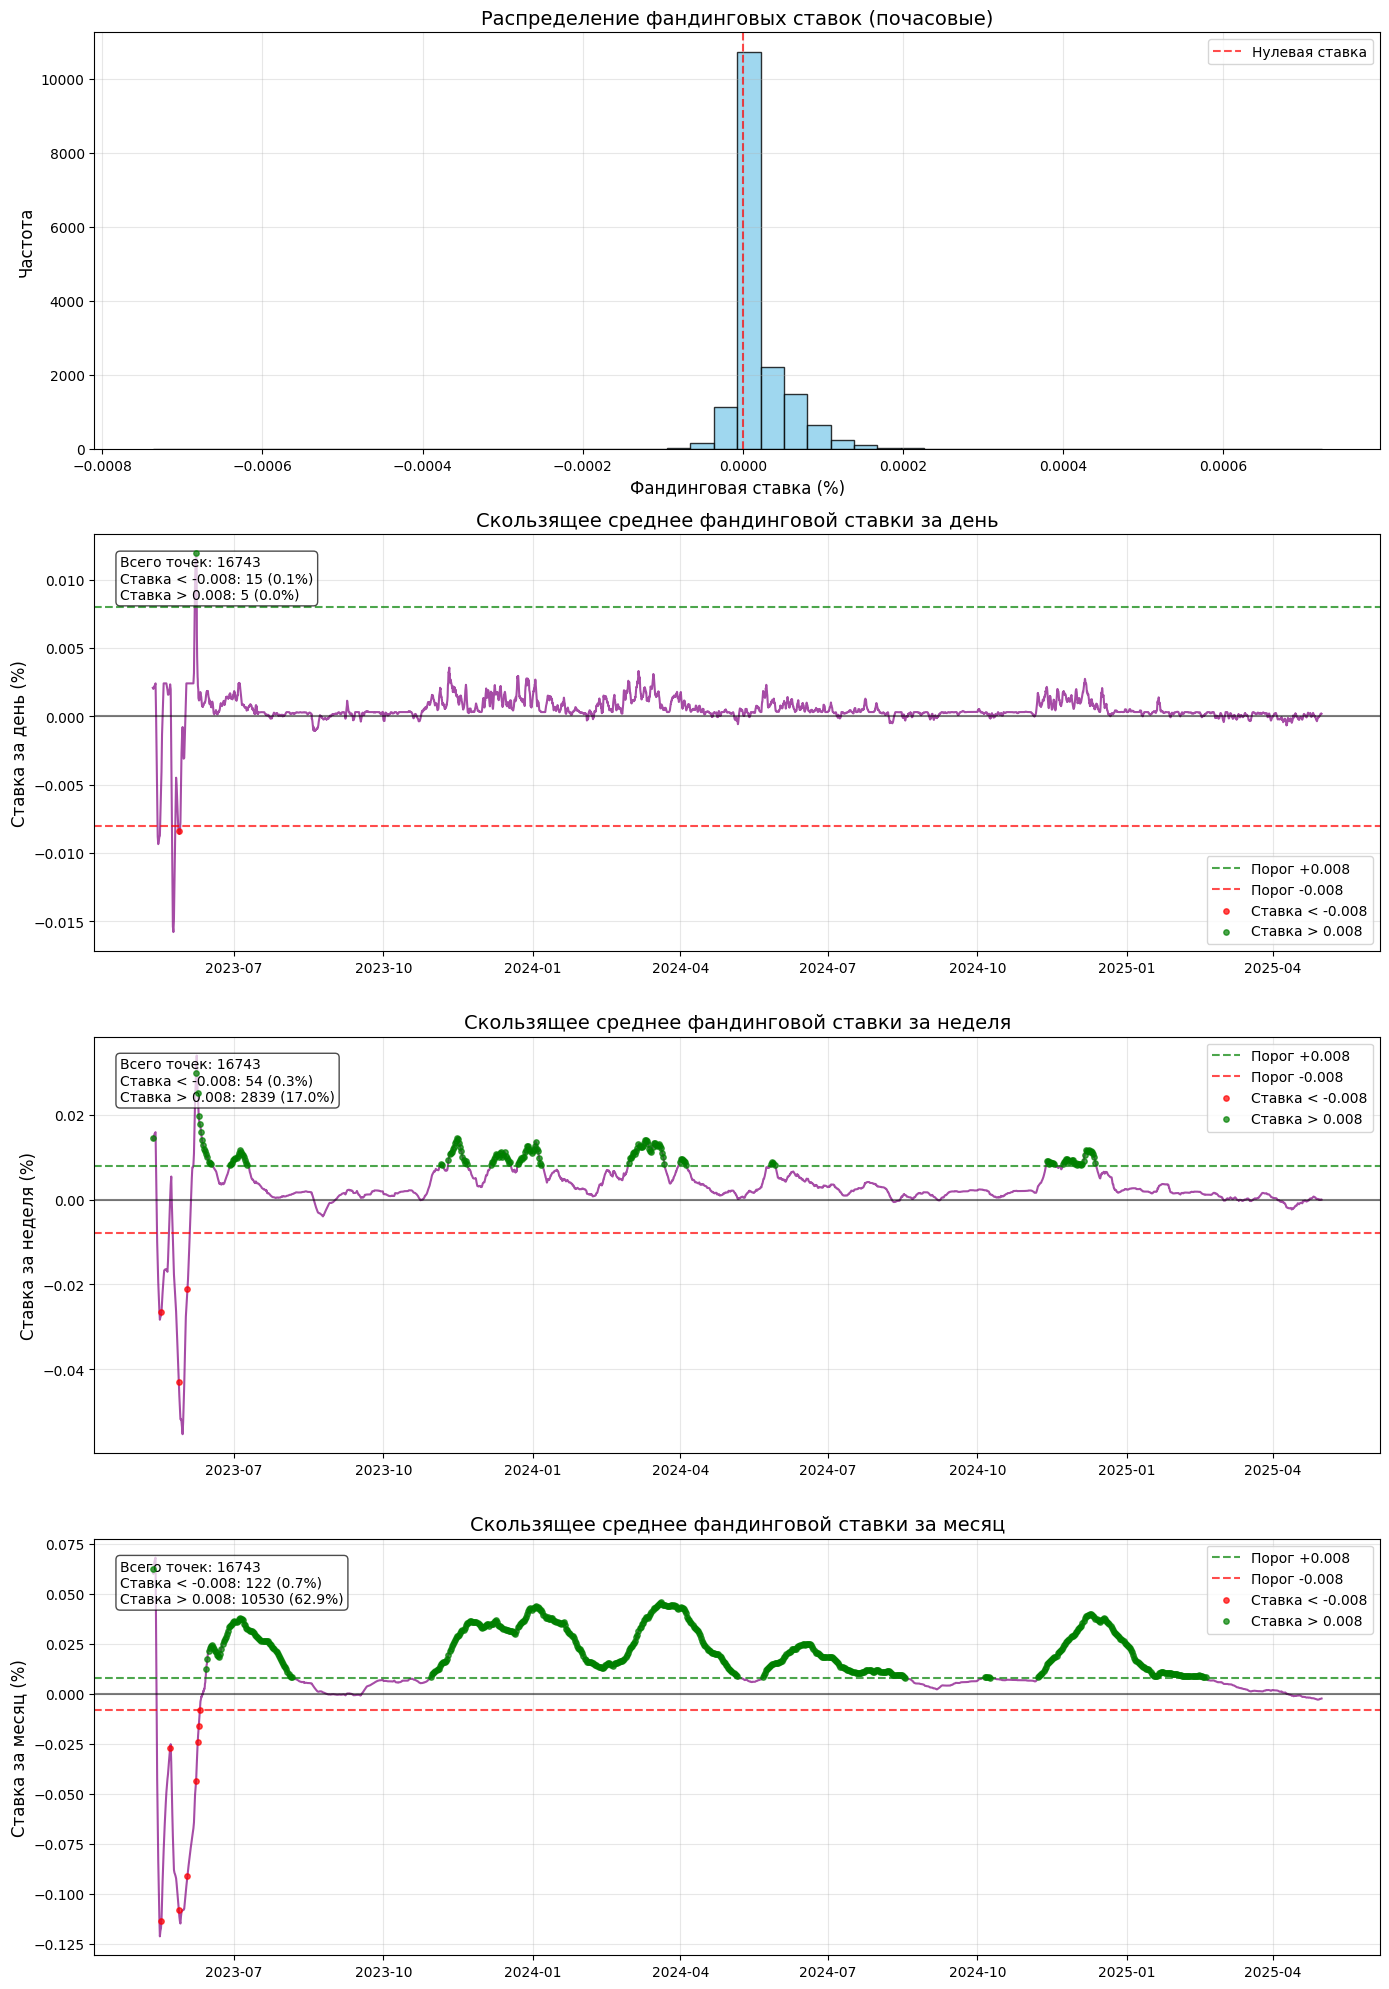

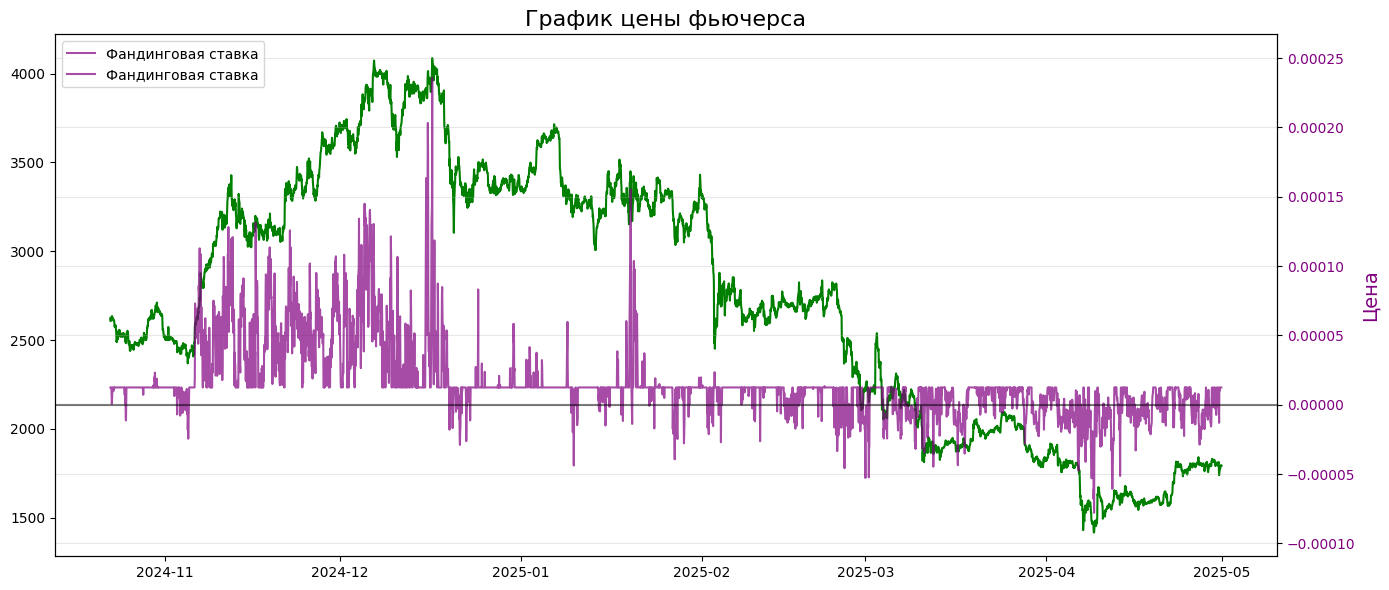


Результаты анализа фандинговой ставки:
день: Ставка < -0.008: 0.1% (15 из 16743), Ставка > 0.008: 0.0% (5 из 16743)
неделя: Ставка < -0.008: 0.3% (54 из 16743), Ставка > 0.008: 17.0% (2839 из 16743)
месяц: Ставка < -0.008: 0.7% (122 из 16743), Ставка > 0.008: 62.9% (10530 из 16743)


In [86]:
ETH_frs = HyperliquidFundingRatesLoader(ticker = 'ETH', start_time=start_time, end_time=end_time).read(with_run=True)
ETH_future_prices = HyperLiquidPerpsPricesLoader(ticker='ETH', interval='1h', start_time=start_time, end_time=end_time).read(with_run=True)

threshold = 0.008
results, period_data = analyze_funding_rate_moving_average(
    ETH_frs,
    threshold=0.008,
    figsize=(14, 20),
    periods={'день': ('1D', 24), 'неделя': ('7D', 168), 'месяц': ('30D', 720)}
)

plot_futures_price(ETH_future_prices, ETH_frs, threshold=0.008)

print("\nРезультаты анализа фандинговой ставки:")
for period, stats in results.items():
    print(f"{period}: Ставка < -{threshold}: {stats['negative_threshold_percentage']:.1f}% ({stats['negative_threshold_periods']} из {stats['total_periods']}), "
          f"Ставка > {threshold}: {stats['positive_threshold_percentage']:.1f}% ({stats['positive_threshold_periods']} из {stats['total_periods']})")

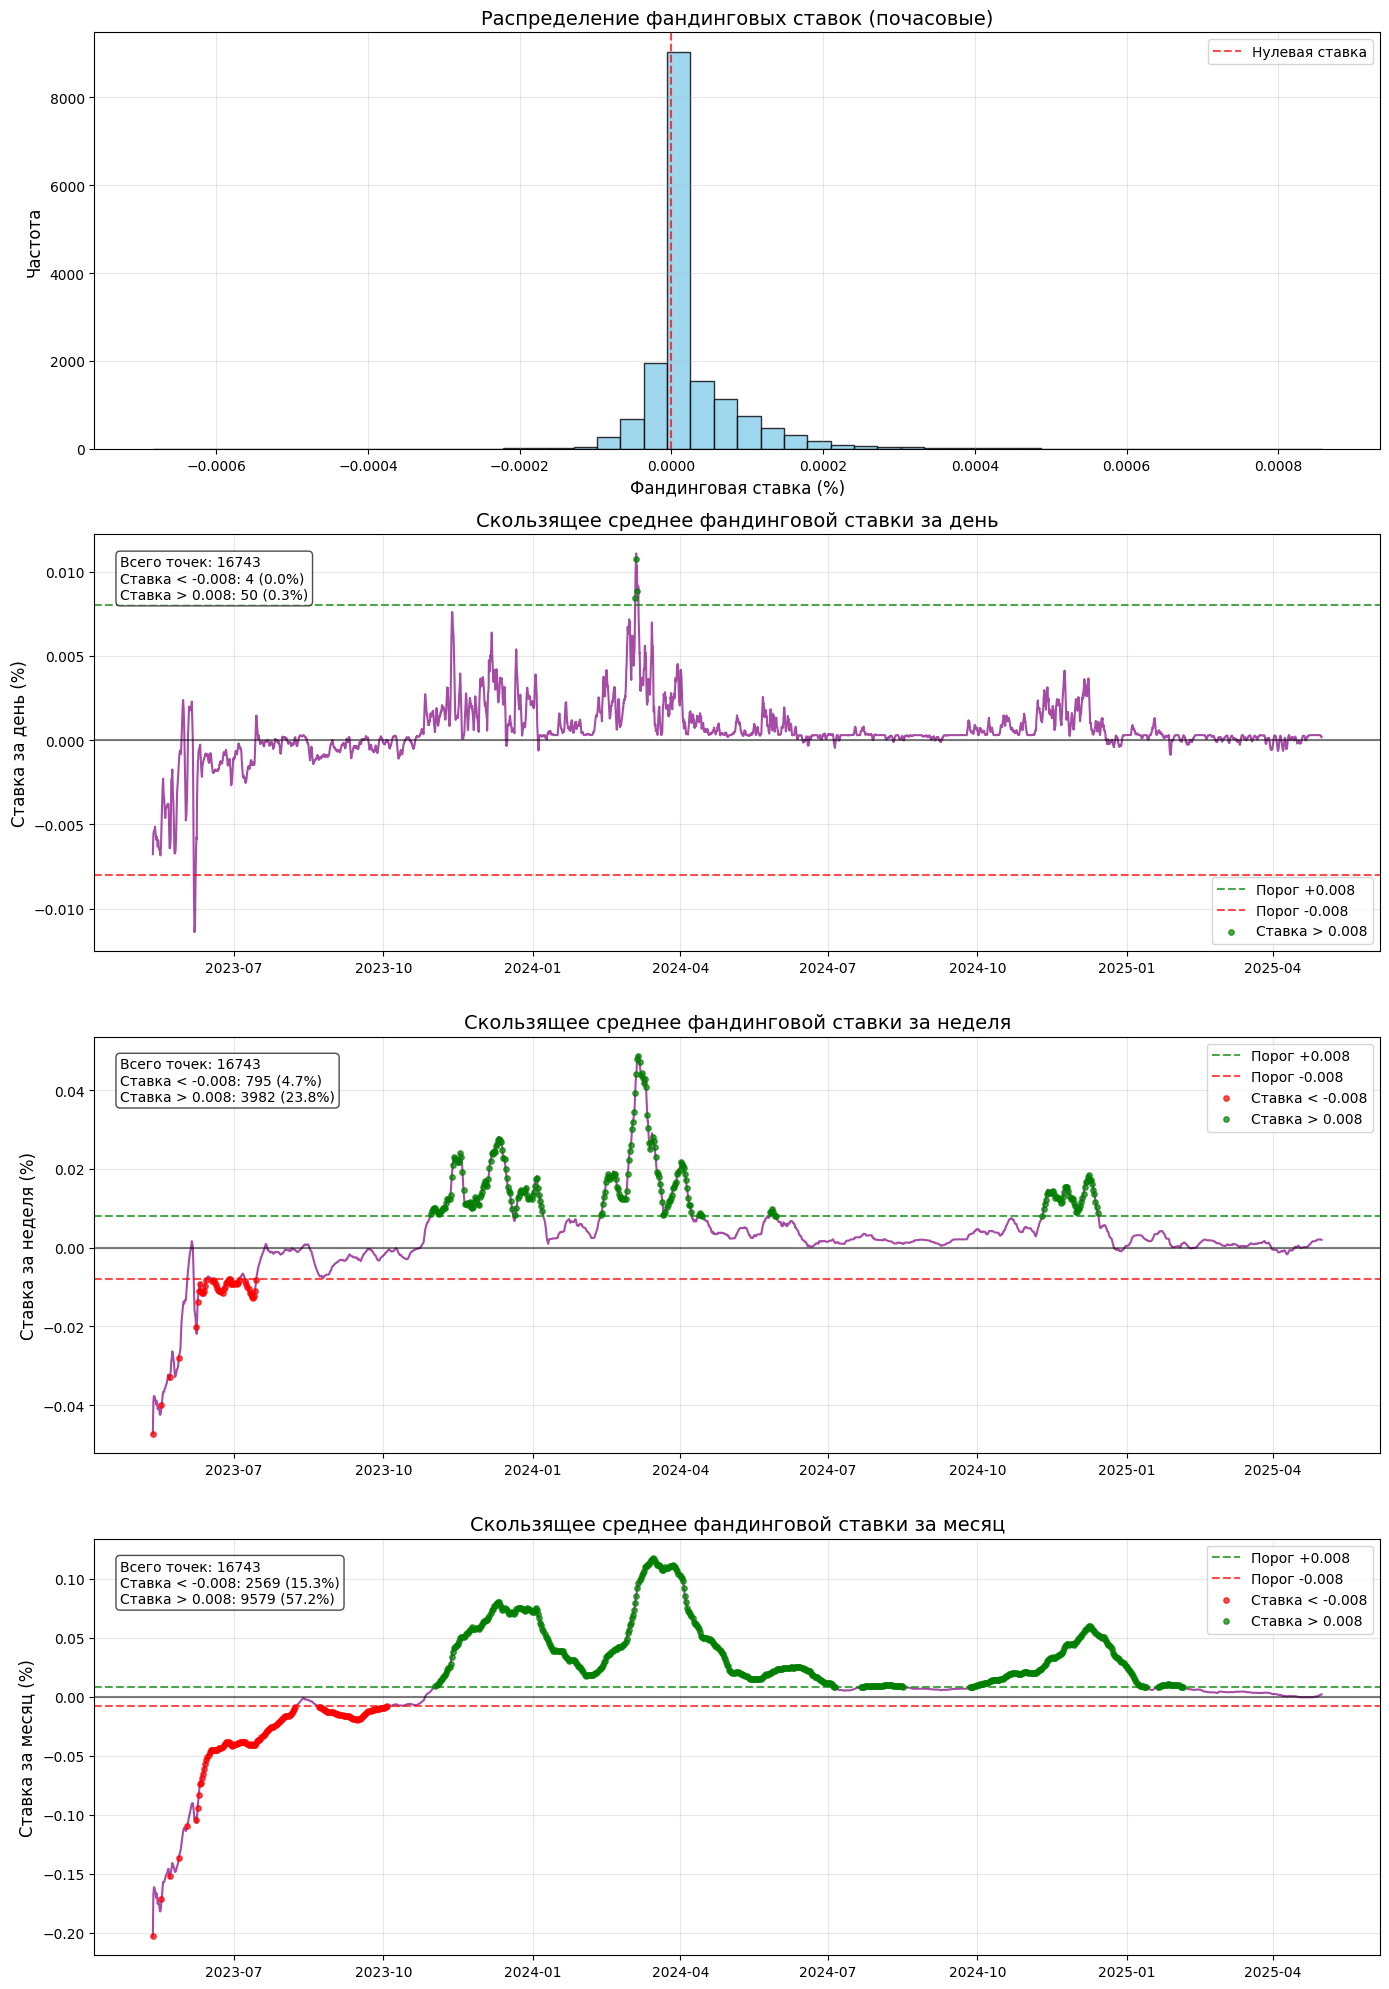

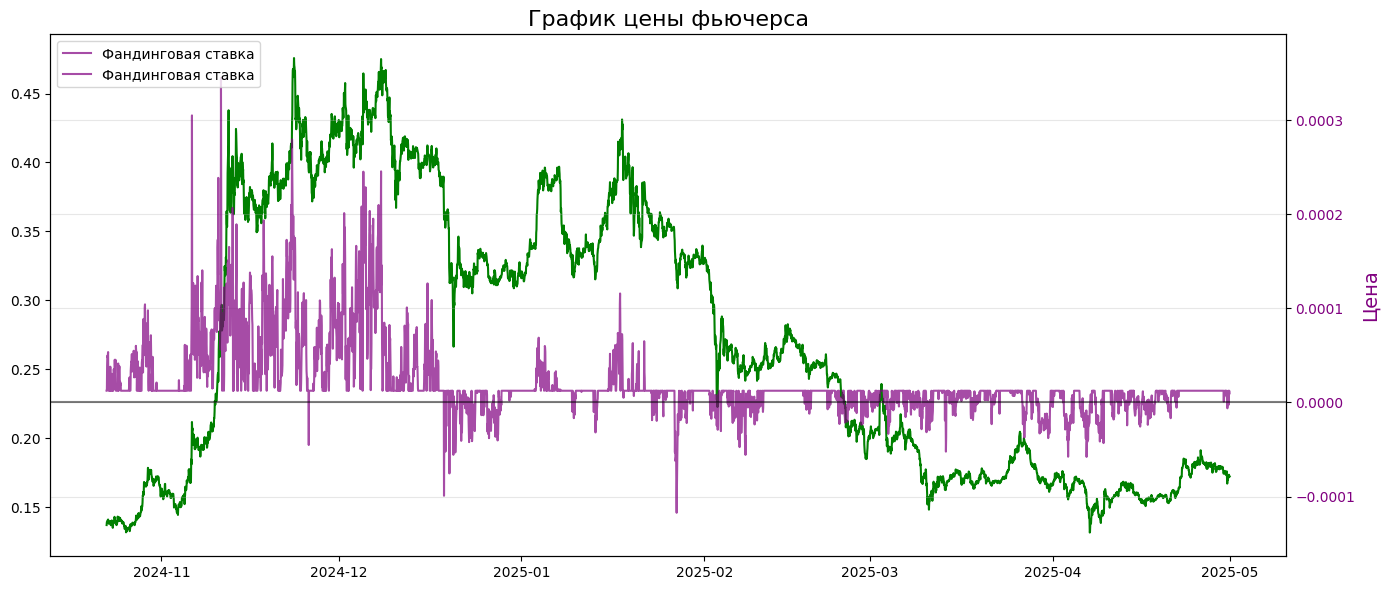


Результаты анализа фандинговой ставки:
день: Ставка < -0.008: 0.0% (4 из 16743), Ставка > 0.008: 0.3% (50 из 16743)
неделя: Ставка < -0.008: 4.7% (795 из 16743), Ставка > 0.008: 23.8% (3982 из 16743)
месяц: Ставка < -0.008: 15.3% (2569 из 16743), Ставка > 0.008: 57.2% (9579 из 16743)


In [87]:
DOGE_frs = HyperliquidFundingRatesLoader(ticker = 'DOGE', start_time=start_time, end_time=end_time).read(with_run=True)
DOGE_futures_prices = HyperLiquidPerpsPricesLoader(ticker='DOGE', interval='1h', start_time=start_time, end_time=end_time).read(with_run=True)

threshold = 0.008
results, period_data = analyze_funding_rate_moving_average(
    DOGE_frs,
    threshold=0.008,
    figsize=(14, 20),
    periods={'день': ('1D', 24), 'неделя': ('7D', 168), 'месяц': ('30D', 720)}
)

plot_futures_price(DOGE_futures_prices, DOGE_frs, threshold=0.008)

print("\nРезультаты анализа фандинговой ставки:")
for period, stats in results.items():
    print(f"{period}: Ставка < -{threshold}: {stats['negative_threshold_percentage']:.1f}% ({stats['negative_threshold_periods']} из {stats['total_periods']}), "
          f"Ставка > {threshold}: {stats['positive_threshold_percentage']:.1f}% ({stats['positive_threshold_periods']} из {stats['total_periods']})")

По Анализу DOGE видно, что большая часть периодов когда ставка могла покрыть расходы на ребалансировку - приходится именно на период с 07.23 по 10.23. Такое же будет наблюдаться и на других активах.

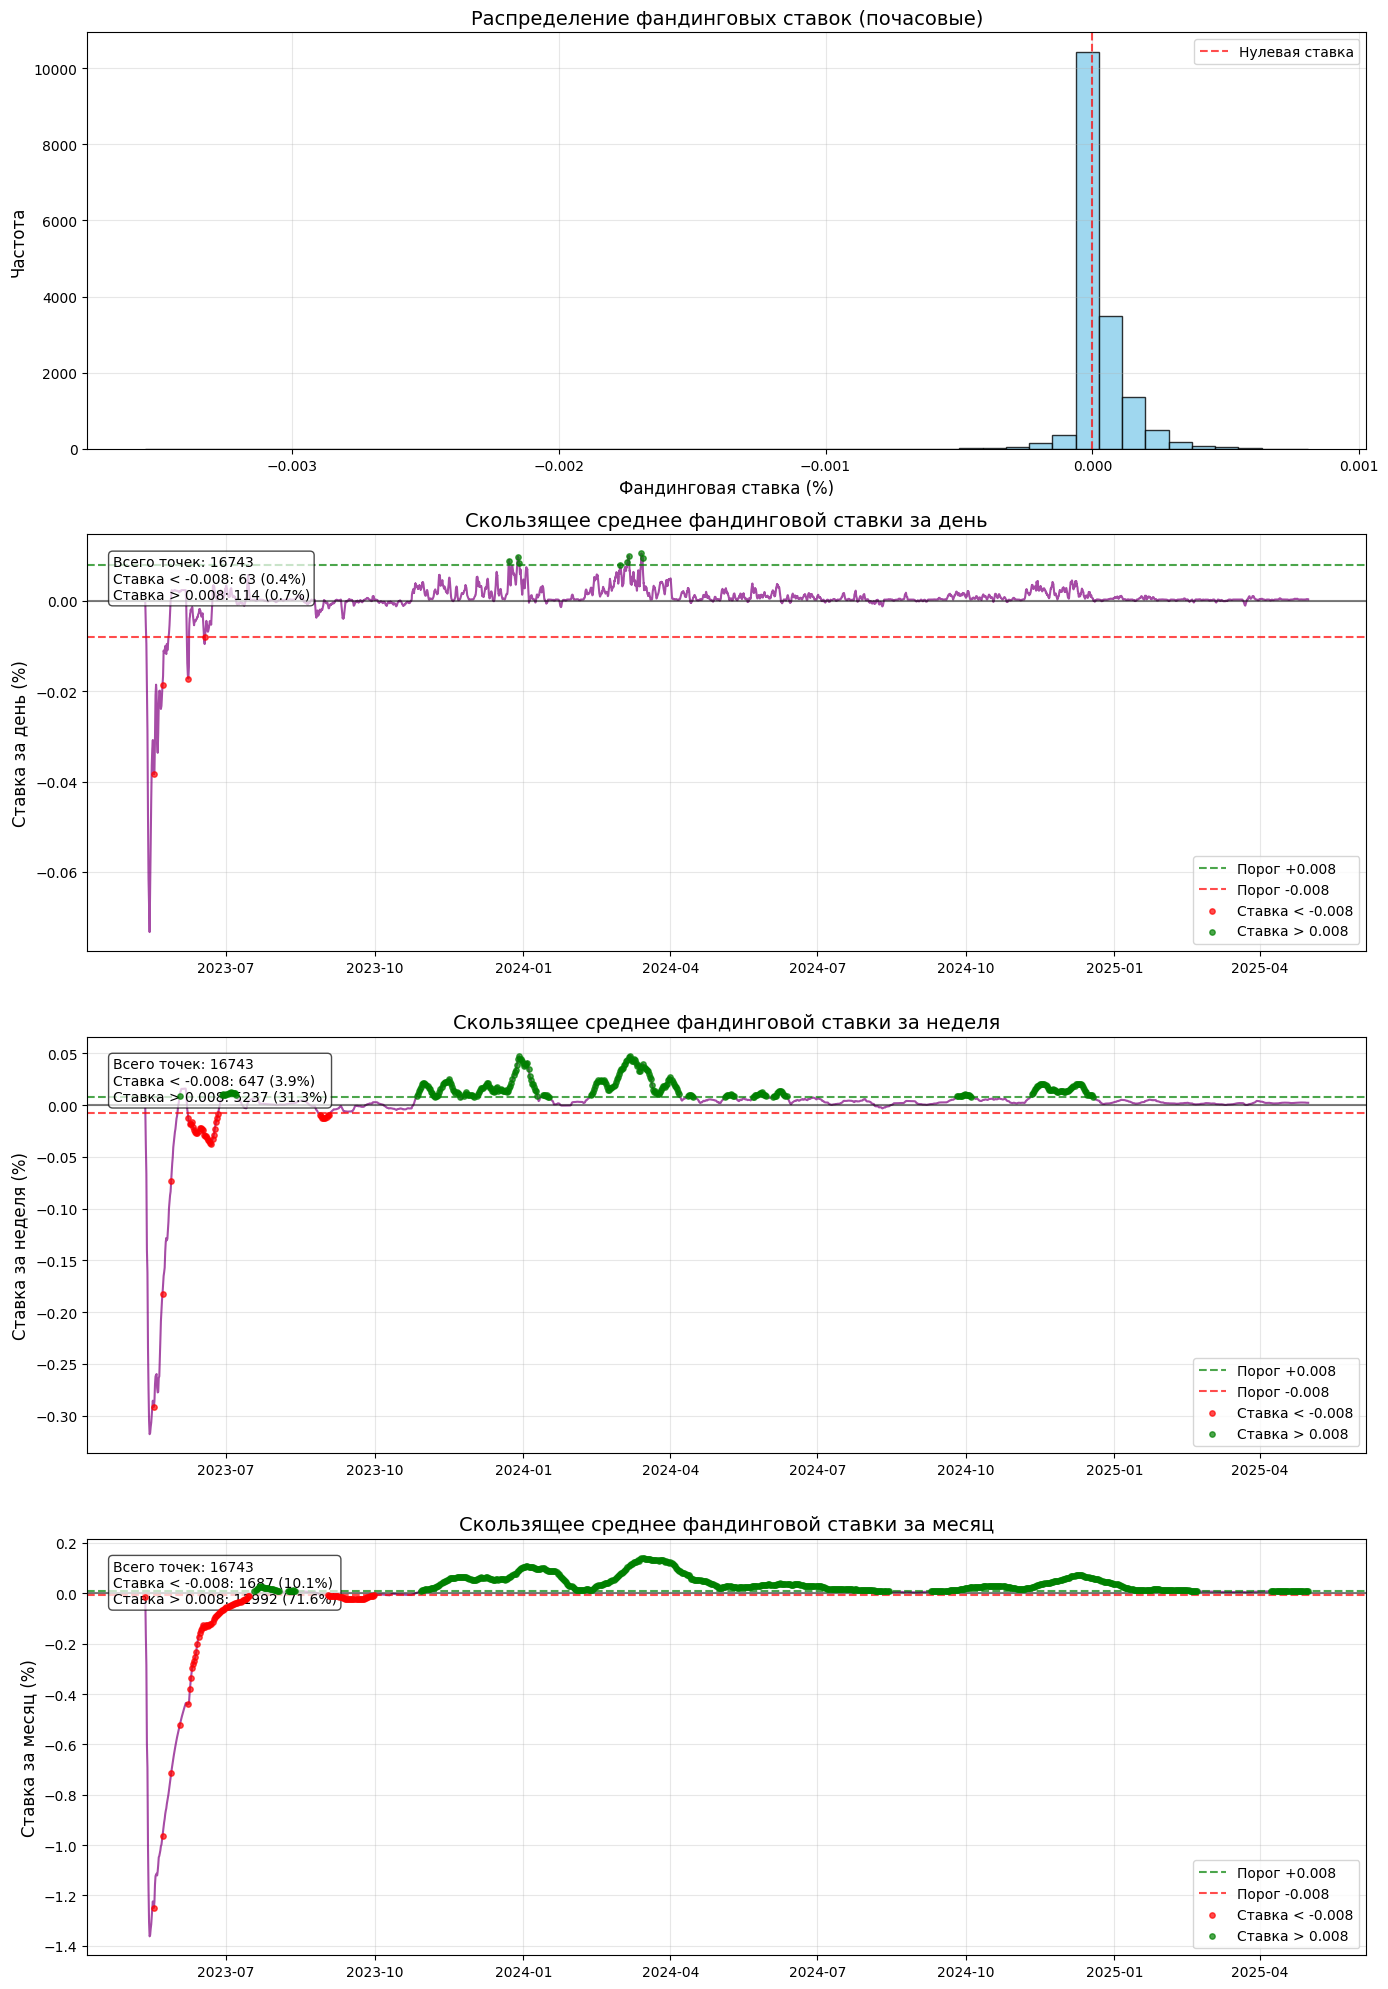

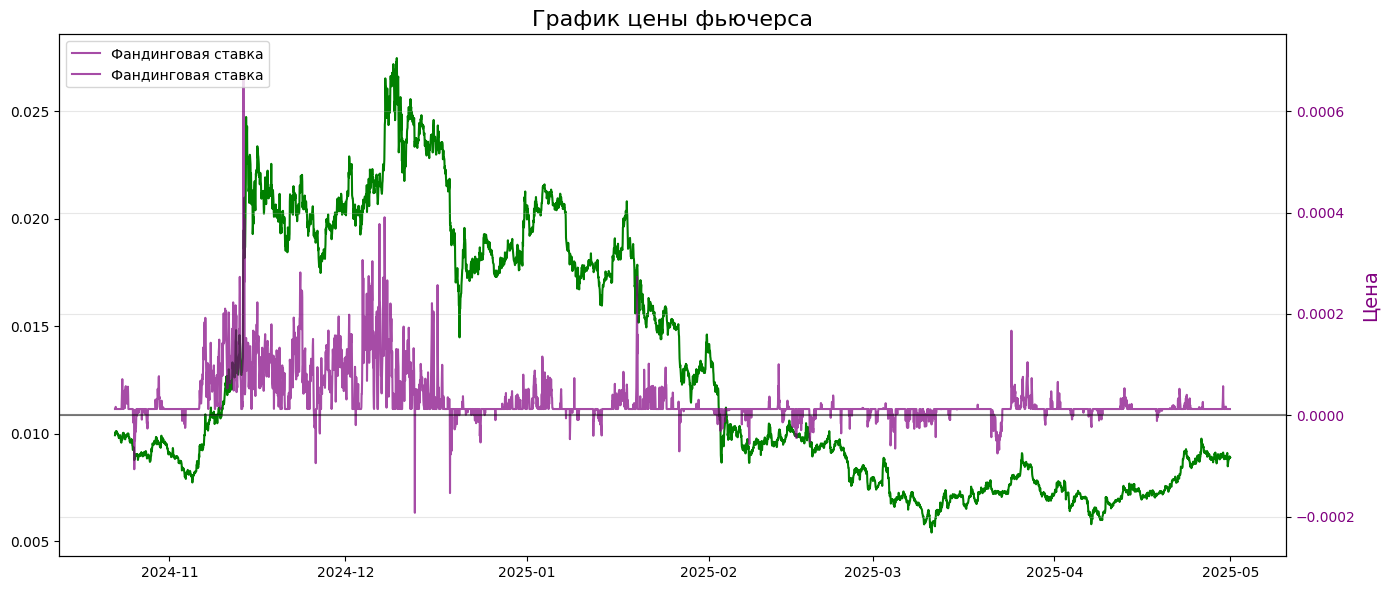


Результаты анализа фандинговой ставки:
день: Ставка < -0.008: 0.4% (63 из 16743), Ставка > 0.008: 0.7% (114 из 16743)
неделя: Ставка < -0.008: 3.9% (647 из 16743), Ставка > 0.008: 31.3% (5237 из 16743)
месяц: Ставка < -0.008: 10.1% (1687 из 16743), Ставка > 0.008: 71.6% (11992 из 16743)


In [88]:
PEPE_frs = HyperliquidFundingRatesLoader(ticker = 'kPEPE', start_time=start_time, end_time=end_time).read(with_run=True)
PEPE_futures_prices = HyperLiquidPerpsPricesLoader(ticker='kPEPE', interval='1h', start_time=start_time, end_time=end_time).read(with_run=True)

threshold = 0.008
results, period_data = analyze_funding_rate_moving_average(
    PEPE_frs,
    threshold=0.008,
    figsize=(14, 20),
    periods={'день': ('1D', 24), 'неделя': ('7D', 168), 'месяц': ('30D', 720)}
)

plot_futures_price(PEPE_futures_prices, PEPE_frs, threshold=0.008)

print("\nРезультаты анализа фандинговой ставки:")
for period, stats in results.items():
    print(f"{period}: Ставка < -{threshold}: {stats['negative_threshold_percentage']:.1f}% ({stats['negative_threshold_periods']} из {stats['total_periods']}), "
          f"Ставка > {threshold}: {stats['positive_threshold_percentage']:.1f}% ({stats['positive_threshold_periods']} из {stats['total_periods']})")

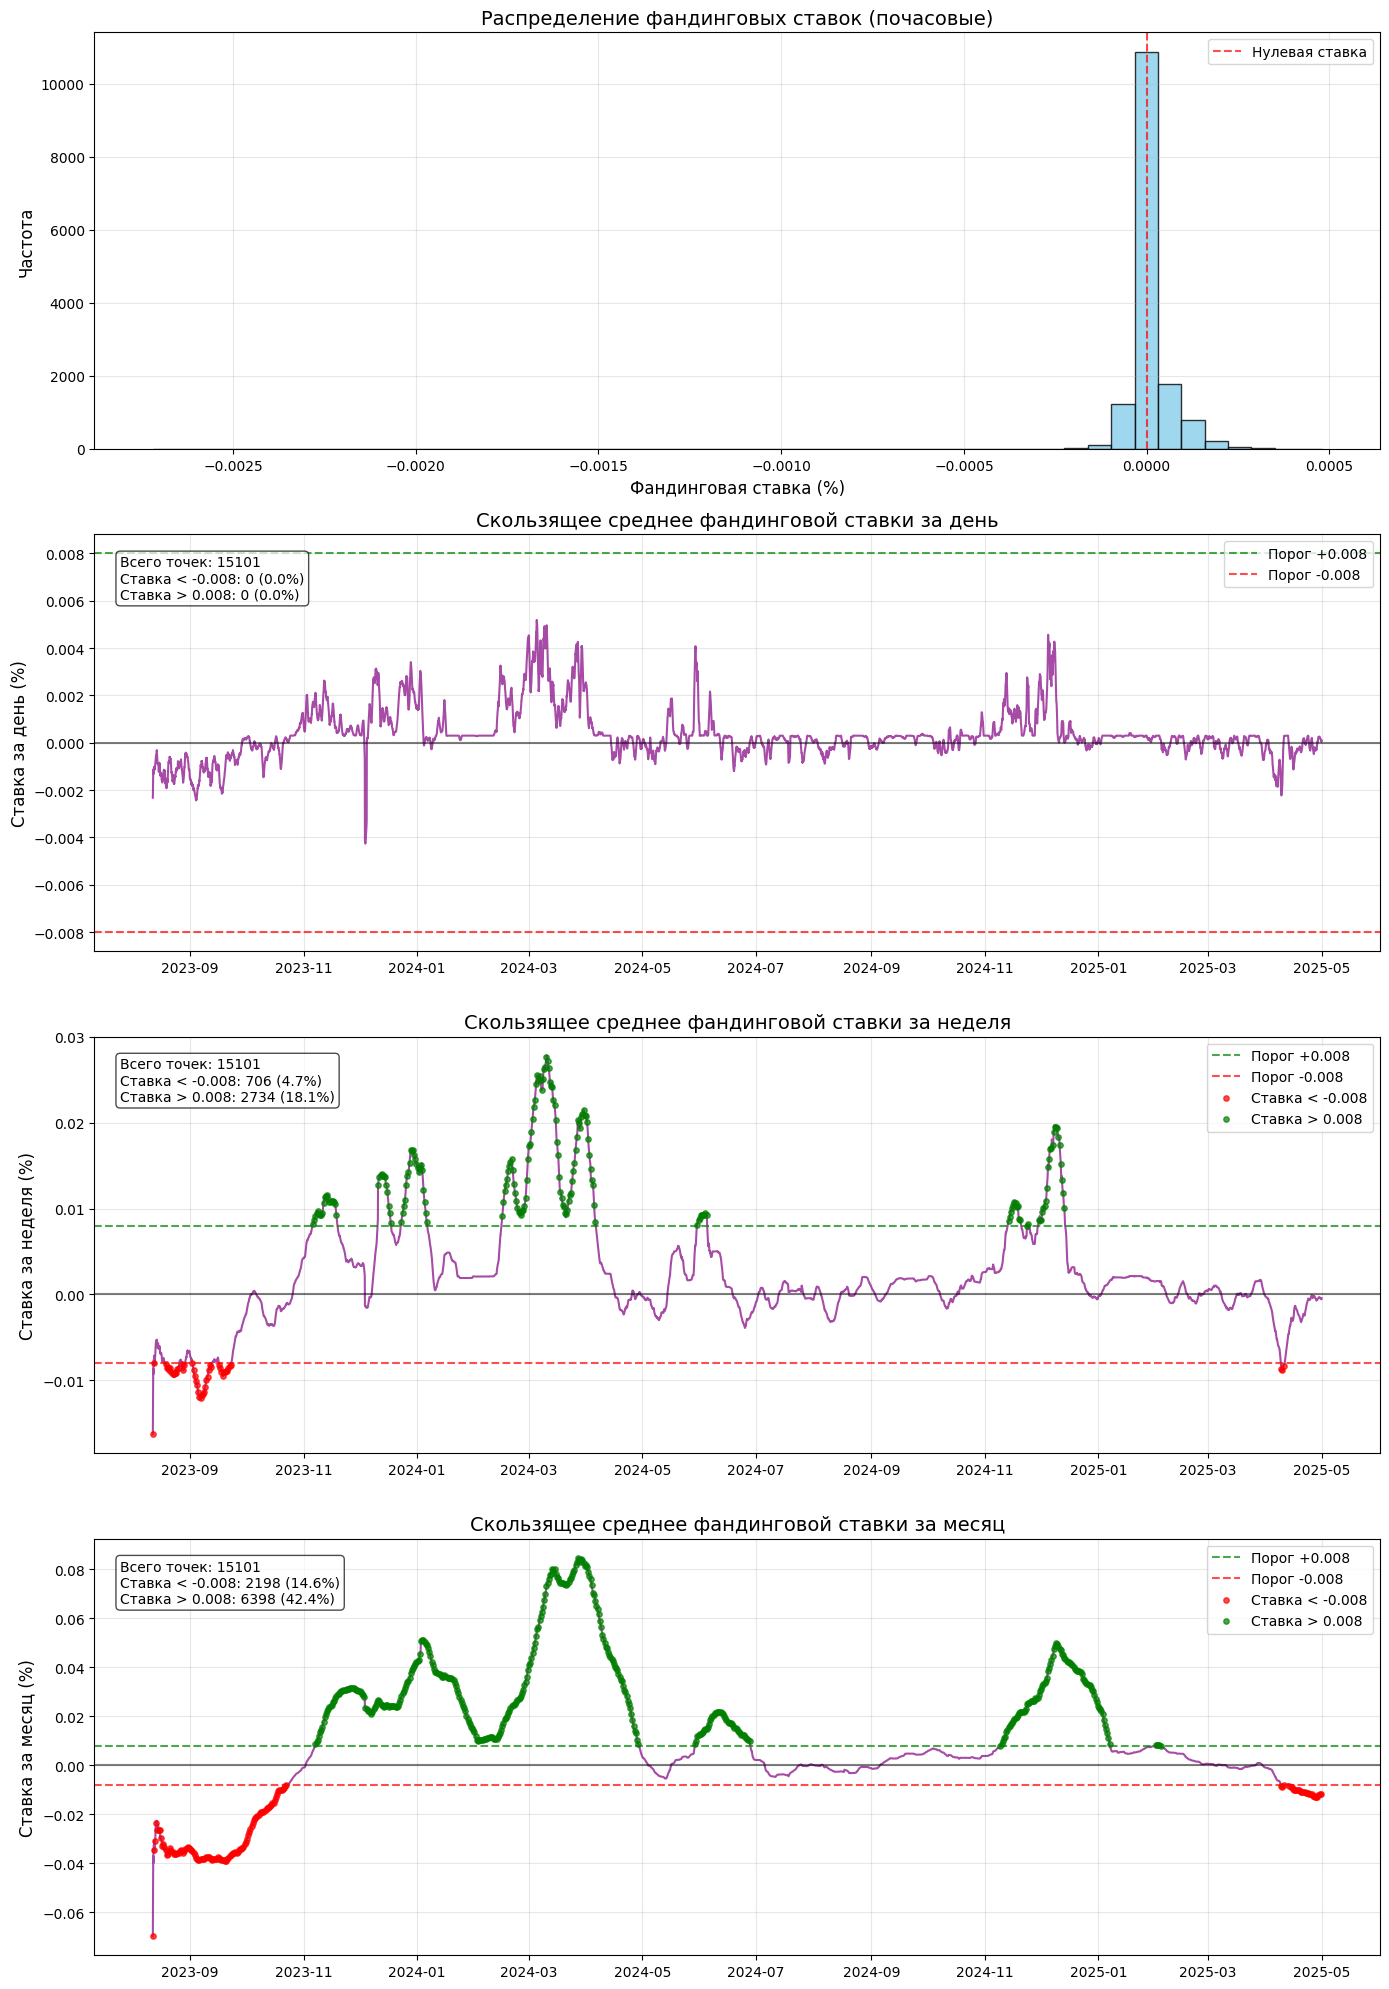

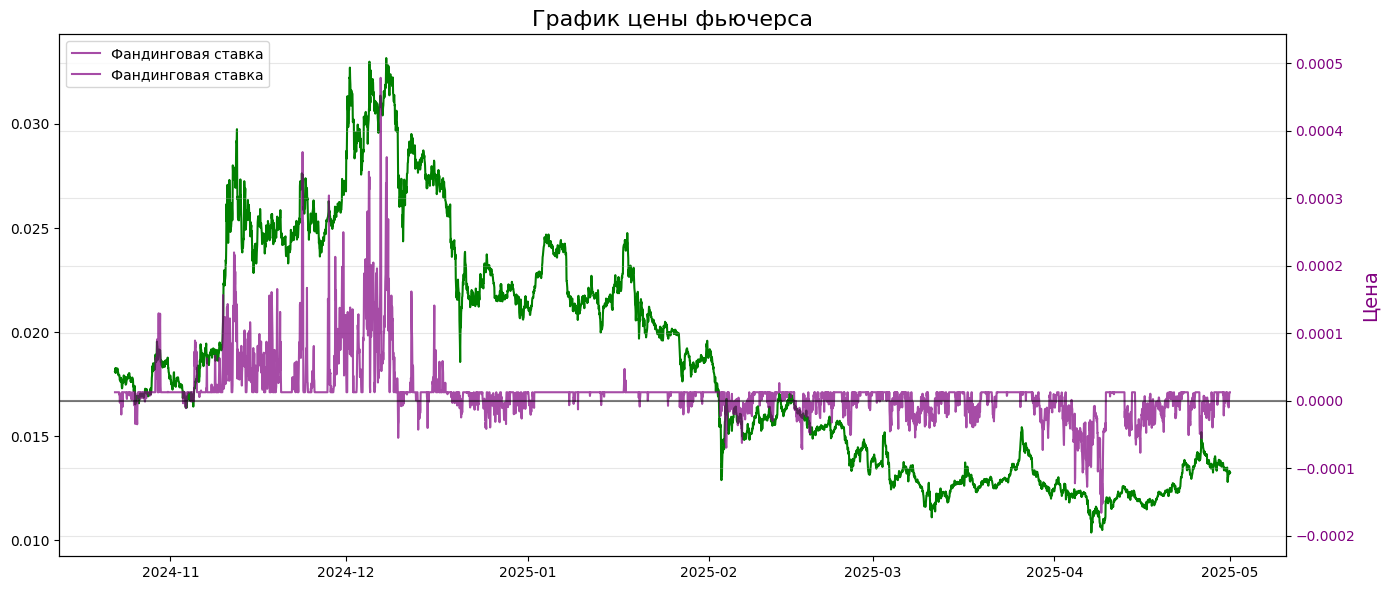


Результаты анализа фандинговой ставки:
день: Ставка < -0.008: 0.0% (0 из 15101), Ставка > 0.008: 0.0% (0 из 15101)
неделя: Ставка < -0.008: 4.7% (706 из 15101), Ставка > 0.008: 18.1% (2734 из 15101)
месяц: Ставка < -0.008: 14.6% (2198 из 15101), Ставка > 0.008: 42.4% (6398 из 15101)


In [89]:
SHIB_frs = HyperliquidFundingRatesLoader(ticker = 'kSHIB', start_time=start_time, end_time=end_time).read(with_run=True)
SHIB_futures_prices = HyperLiquidPerpsPricesLoader(ticker='kSHIB', interval='1h', start_time=start_time, end_time=end_time).read(with_run=True)

threshold = 0.008
results, period_data = analyze_funding_rate_moving_average(
    SHIB_frs,
    threshold=0.008,
    figsize=(14, 20),
    periods={'день': ('1D', 24), 'неделя': ('7D', 168), 'месяц': ('30D', 720)}
)

plot_futures_price(SHIB_futures_prices, SHIB_frs, threshold=0.008)

print("\nРезультаты анализа фандинговой ставки:")
for period, stats in results.items():
    print(f"{period}: Ставка < -{threshold}: {stats['negative_threshold_percentage']:.1f}% ({stats['negative_threshold_periods']} из {stats['total_periods']}), "
          f"Ставка > {threshold}: {stats['positive_threshold_percentage']:.1f}% ({stats['positive_threshold_periods']} из {stats['total_periods']})")

Тут видим что и у PEPE и у SHIB (как и у DOGE) буквально есть период, когда высокая отрицательная ставка возобладает. Как эти периоды находить - уже другой вопрос.

#Выводы

По данным, которые мы нашли - у PEPE, SHIB и DOGE существуют буквально периоды когда отрицательная ставка по фандингу может покрыть расходы на ребалансировку и помочь увеличить PnL. Однако как определить такой период и его длительность - другой вопрос.


[есть очень много периодов длины день или неделя когда фандиговая ставка большую часть времени(>70%) была отрицательной - это очень хороший маркер для того, чтобы зайти в эти рынки для торговли по нашей стратегии, так как велик шанс того, что мы можем попасть в длительный период с отрицательной ставкой.]

#Поиск топ 3 окон с наилучшей фандинговой ставкой

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def find_top_windows_for_negative_funding(rate_df, rate_col='rate', threshold=0.008,
                                        window_ranges=[1, 2, 3, 5, 7, 10, 14, 21, 30, 45, 60],
                                        top_n=3, plot_results=True, figsize=(14, 10)):
    """
    Находит топ-N размеров окна с наибольшим процентом отрицательных фандинговых ставок,
    превышающих по модулю пороговое значение (т.е. <-threshold).

    Параметры:
    rate_df (pd.DataFrame): DataFrame с индексом времени и столбцом ставок
    rate_col (str): имя столбца со ставками
    threshold (float): пороговое значение для отметки на графике
    window_ranges (list): список дней для различных размеров окон
    top_n (int): количество топовых окон для анализа и отображения
    plot_results (bool): нужно ли визуализировать результаты
    figsize (tuple): размер графика
    """
    results = {}
    period_data = {}

    # Создаем список периодов на основе диапазона окон
    periods = {}
    for days in window_ranges:
        period_name = f'{days}D'
        window = f'{days}D'
        hours_multiplier = days * 24
        periods[period_name] = (window, hours_multiplier)

    # Подсчитываем скользящее среднее для каждого периода
    for period_name, (window, hours_multiplier) in periods.items():
        # Скользящее окно с подсчетом среднего значения ставки
        window_size = pd.Timedelta(window)

        # Создаем пустую серию для результатов
        avg_series = pd.Series(index=rate_df.index, dtype=float)

        # Для каждой точки времени вычисляем среднюю ставку по предыдущему окну
        for i in range(len(rate_df)):
            current_time = rate_df.index[i]
            window_start = current_time - window_size
            window_data = rate_df[(rate_df.index >= window_start) & (rate_df.index <= current_time)]

            if len(window_data) > 0:
                # Среднее значение ставки за период
                avg_rate = window_data[rate_col].mean()
                # Приводим к ставке за весь период (умножаем на количество часов)
                avg_series.iloc[i] = avg_rate * hours_multiplier

        # Добавляем результаты в словарь
        period_data[period_name] = avg_series

        # Считаем количество периодов, где средняя ставка < -threshold (отрицательная сильная)
        negative_high_mask = avg_series < -threshold
        negative_high_count = negative_high_mask.sum()

        results[period_name] = {
            'total_periods': len(avg_series),
            'negative_threshold_periods': negative_high_count,
            'window_days': int(period_name[:-1]),  # Убираем 'D' из имени периода
            'negative_threshold_percentage': (negative_high_count / len(avg_series) * 100) if len(avg_series) > 0 else 0
        }

    # Сортируем результаты по проценту отрицательных ставок (по убыванию)
    sorted_results = sorted(results.items(),
                           key=lambda x: x[1]['negative_threshold_percentage'],
                           reverse=True)

    # Выбираем топ-N окон
    top_windows = sorted_results[:top_n]
    top_window_names = [item[0] for item in top_windows]

    print(f"Топ-{top_n} окон с наибольшим процентом отрицательных ставок < -{threshold}:")
    for window_name, stats in top_windows:
        days = stats['window_days']
        print(f"Окно {days} дней: {stats['negative_threshold_percentage']:.2f}% "
              f"({stats['negative_threshold_periods']} из {stats['total_periods']})")

    # Визуализация результатов
    if plot_results:
        # +1 для гистограммы распределения ставок
        fig, axes = plt.subplots(top_n + 1, 1, figsize=figsize)

        # Гистограмма распределения ставок
        axes[0].hist(rate_df[rate_col], bins=50, color='skyblue', edgecolor='black', alpha=0.8)
        axes[0].axvline(x=0, color='black', linestyle='-', alpha=0.5, label='Нулевая ставка')
        axes[0].axvline(x=-threshold, color='red', linestyle='--', alpha=0.7, label=f'Порог -{threshold}')
        axes[0].set_title('Распределение фандинговых ставок (почасовые)', fontsize=14)
        axes[0].set_xlabel('Фандинговая ставка (%)', fontsize=12)
        axes[0].set_ylabel('Частота', fontsize=12)
        axes[0].grid(alpha=0.3)
        axes[0].legend()

        # Графики скользящего среднего ставки для топ-N окон
        for i, window_name in enumerate(top_window_names, 1):
            series = period_data[window_name]
            days = results[window_name]['window_days']

            axes[i].plot(series.index, series.values,
                        linestyle='-', color='purple', alpha=0.7)

            # Добавляем линии уровней
            axes[i].axhline(y=0, color='black', linestyle='-', alpha=0.5)
            axes[i].axhline(y=threshold, color='green', linestyle='--', alpha=0.7, label=f'Порог +{threshold}')
            axes[i].axhline(y=-threshold, color='red', linestyle='--', alpha=0.7, label=f'Порог -{threshold}')

            # Выделение периодов с высоким отрицательным значением ставки
            negative_high_mask = series < -threshold

            # Чтобы не перегружать график точками, возьмем каждую N-ю точку
            sample_step = max(1, len(series) // 1000)  # Примерно 1000 точек максимум
            sample_indices = np.arange(0, len(series), sample_step)

            # Отмечаем высокие отрицательные ставки (ниже -threshold)
            if negative_high_mask.iloc[sample_indices].sum() > 0:
                sample_mask = pd.Series(False, index=series.index)
                sample_mask.iloc[sample_indices] = True
                points_mask = negative_high_mask & sample_mask

                axes[i].scatter(series.index[points_mask],
                               series.values[points_mask],
                               color='red', s=15, zorder=5, alpha=0.7,
                               label=f'Ставка < -{threshold}')

            axes[i].set_title(f'Окно {days} дней - {results[window_name]["negative_threshold_percentage"]:.2f}% отрицательных ставок < -{threshold}', fontsize=14)
            axes[i].set_ylabel(f'Ставка за {days} дней (%)', fontsize=12)
            axes[i].grid(alpha=0.3)
            axes[i].legend()

            # Аннотация с результатами
            stats_text = (f"Всего точек: {results[window_name]['total_periods']}\n"
                         f"Ставка < -{threshold}: {results[window_name]['negative_threshold_periods']} "
                         f"({results[window_name]['negative_threshold_percentage']:.2f}%)")

            axes[i].annotate(stats_text, xy=(0.02, 0.95), xycoords='axes fraction',
                            ha='left', va='top',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

        plt.tight_layout()
        plt.show()

    return dict(top_windows), period_data

def plot_futures_price(futures_df, rate_df=None, rate_col='rate', price_col='price', threshold=0.008, figsize=(14, 6)):
    """
    Рисует график цены фьючерса на отдельной картинке.
    Если предоставлен DataFrame с фандинговой ставкой, также отмечает периоды с отрицательной ставкой.
    """
    plt.figure(figsize=figsize)

    # Рисуем график цены фьючерса
    plt.plot(futures_df.index, futures_df[price_col], color='green', label='Цена фьючерса')

    # Если предоставлен DataFrame с фандинговой ставкой
    if rate_df is not None:
        # Объединяем данные для корректного отображения
        combined_df = pd.merge(futures_df[[price_col]], rate_df[[rate_col]],
                             left_index=True, right_index=True, how='inner')

        # Отмечаем точки, где фандинговая ставка отрицательна
        negative_mask = combined_df[rate_col] < -threshold
        if negative_mask.sum() > 0:
            plt.scatter(combined_df.index[negative_mask],
                       combined_df[price_col][negative_mask],
                       color='red', s=10, zorder=5,
                       label=f'Цена при ставке < -{threshold}')

        # Находим непрерывные периоды с отрицательной ставкой ниже порога
        neg_periods = []
        start_idx = None

        for i in range(len(combined_df.index)):
            if negative_mask.iloc[i]:
                if start_idx is None:
                    start_idx = i
            elif start_idx is not None:
                neg_periods.append((start_idx, i-1))
                start_idx = None

        if start_idx is not None:  # Если последний период тоже с отрицательной ставкой
            neg_periods.append((start_idx, len(combined_df.index)-1))

        # Добавляем затенение для периодов с отрицательной ставкой ниже порога
        for start, end in neg_periods:
            plt.axvspan(combined_df.index[start], combined_df.index[end],
                      color='red', alpha=0.1)

        # Добавляем вторую ось Y для фандинговой ставки
        ax2 = plt.gca().twinx()
        ax2.plot(combined_df.index, combined_df[rate_col], color='purple', alpha=0.7,
                label='Фандинговая ставка')
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax2.axhline(y=threshold, color='green', linestyle='--', alpha=0.7, label=f'Порог +{threshold}')
        ax2.axhline(y=-threshold, color='red', linestyle='--', alpha=0.7, label=f'Порог -{threshold}')
        ax2.set_ylabel('Фандинговая ставка (%)', color='purple', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='purple')

        # Создаем общую легенду
        lines1, labels1 = plt.gca().get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    else:
        plt.legend()

    plt.title('График цены фьючерса', fontsize=16)
    plt.xlabel('Время', fontsize=14)
    plt.ylabel('Цена', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Пример использования:
# top_windows, period_data = find_top_windows_for_negative_funding(
#     ETH_frs,
#     threshold=0.008,
#     window_ranges=[1, 2, 3, 5, 7, 10, 14, 21, 30, 45, 60],  # Разные размеры окон в днях
#     top_n=3,  # Ищем топ-3 окна
#     figsize=(14, 20)
# )
#
# plot_futures_price(ETH_future_prices, ETH_frs, threshold=0.008)


Топ-3 окон с наибольшим процентом отрицательных ставок < -0.008:
Окно 45 дней: 16.51% (2493 из 15101)
Окно 30 дней: 14.56% (2198 из 15101)
Окно 21 дней: 11.77% (1778 из 15101)


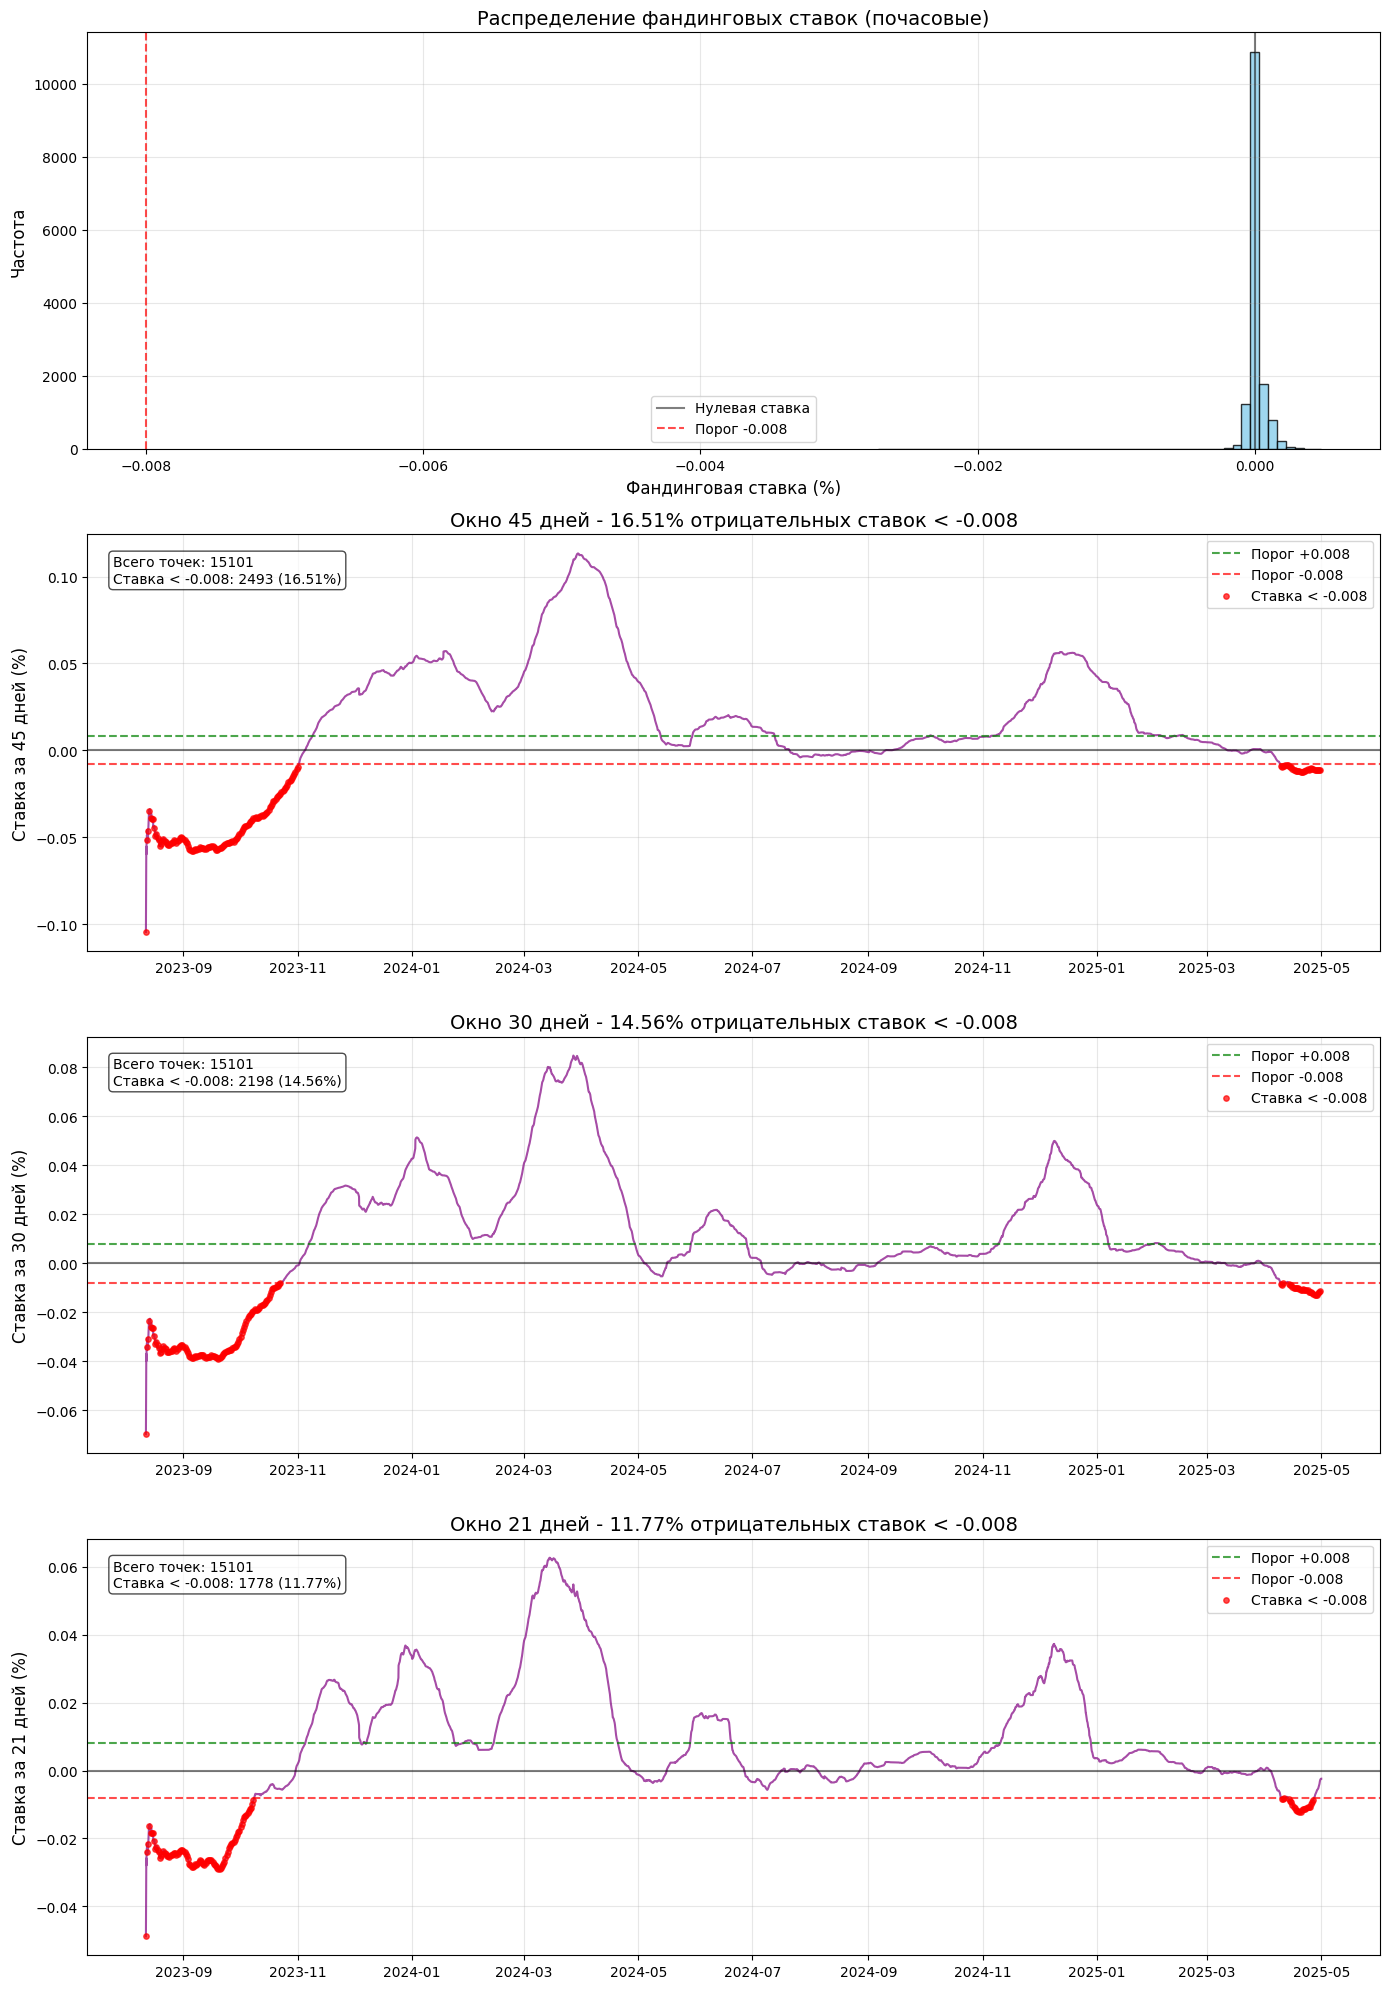

NameError: name 'SHIB_future_prices' is not defined

In [92]:
threshold = 0.008
top_windows, period_data = find_top_windows_for_negative_funding(
    SHIB_frs,
    threshold=0.008,
    window_ranges=[1, 2, 3, 5, 7, 10, 14, 15, 16, 17, 21, 30, 45],  # Разные размеры окон в днях
    top_n=3,  # Ищем топ-3 окна
    figsize=(14, 20)
)

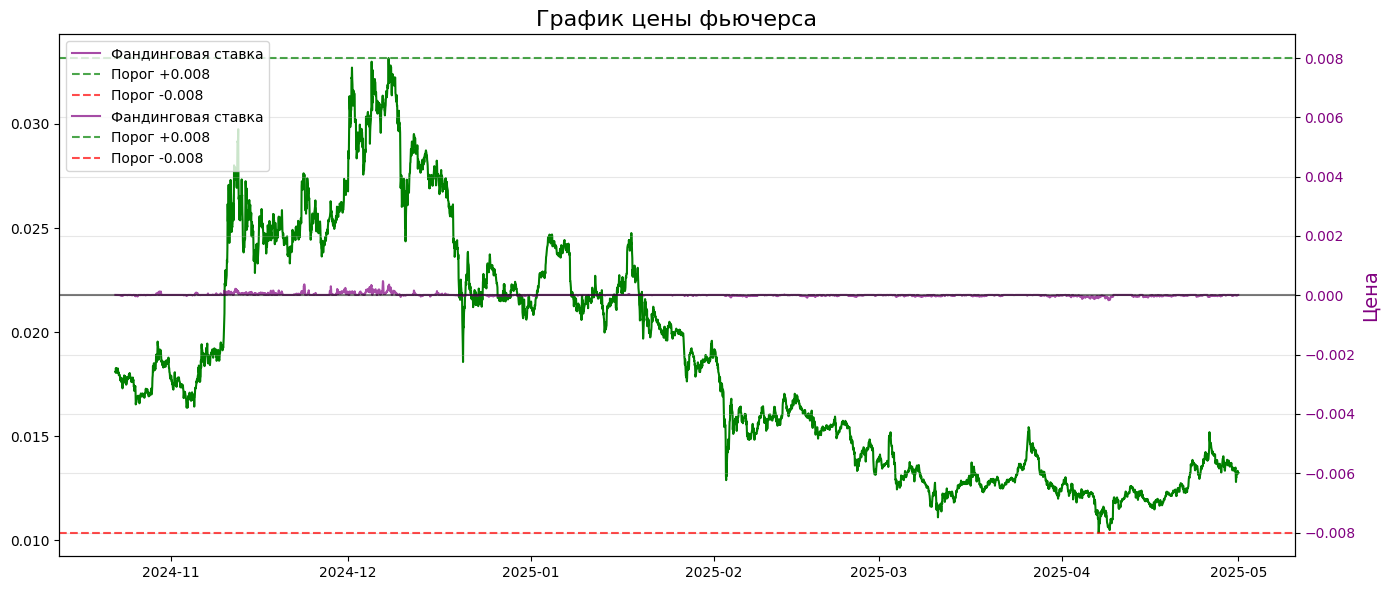

In [93]:
plot_futures_price(SHIB_futures_prices, SHIB_frs, threshold=0.008)

#?

In [82]:
hyperliquid_prices = HyperLiquidPerpsPricesLoader(ticker='ETH', interval='1h').read(with_run=True)

In [83]:
hyperliquid_prices

,price
open_time,
2025-01-01 00:00:00+00:00,3336.8
2025-01-01 01:00:00+00:00,3363.8
2025-01-01 02:00:00+00:00,3347.0
2025-01-01 03:00:00+00:00,3363.4
2025-01-01 04:00:00+00:00,3356.3
...,...
2025-05-18 20:00:00+00:00,2410.2
2025-05-18 21:00:00+00:00,2394.2
2025-05-18 22:00:00+00:00,2407.6


In [84]:
pool_data = UniswapV3EthereumPoolHourDataLoader(api_key=, pool='0x11b815efB8f581194ae79006d24E0d814B7697F6')

SyntaxError: invalid syntax (<ipython-input-84-db2a1753ee3a>, line 1)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

def plot_price_at_negative_funding_from_dfs(price_df, rate_df, price_col='price', rate_col='rate', threshold=0):
    """
    Визуализирует цену актива и отмечает точки, где фандинговая ставка отрицательна.

    Параметры:
    price_df (pd.DataFrame): DataFrame с индексом времени и столбцом цены
    rate_df (pd.DataFrame): DataFrame с индексом времени и столбцом фандинговой ставки
    price_col (str): имя столбца с ценой в price_df
    rate_col (str): имя столбца с фандинговой ставкой в rate_df
    threshold (float): Порог для определения отрицательной ставки (по умолчанию 0)
    """
    # Объединяем два DataFrame по индексу времени
    combined_df = pd.merge(price_df[[price_col]], rate_df[[rate_col]],
                          left_index=True, right_index=True, how='inner')

    # Фильтрация данных для отрицательной фандинговой ставки
    negative_funding_mask = combined_df[rate_col] < threshold
    negative_funding_prices = combined_df.loc[negative_funding_mask, price_col]
    negative_funding_times = combined_df.index[negative_funding_mask]

    # Создаем подграфики: цена сверху, фандинговая ставка снизу
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True,
                                  gridspec_kw={'height_ratios': [2, 1]})

    # График цены
    ax1.plot(combined_df.index, combined_df[price_col], label='Цена актива', color='blue', alpha=0.7)
    ax1.scatter(negative_funding_times, negative_funding_prices, color='red',
                label=f'Отрицательная фандинговая ставка (< {threshold})', zorder=5, s=50)

    # Форматирование графика цены
    ax1.set_title('Цена актива в моменты отрицательной фандинговой ставки', fontsize=16)
    ax1.set_ylabel('Цена', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12)

    # Выделение областей с отрицательной фандинговой ставкой
    for idx in negative_funding_times:
        ax1.axvline(x=idx, color='gray', alpha=0.2)

    # График фандинговой ставки
    ax2.plot(combined_df.index, combined_df[rate_col], color='purple', label='Фандинговая ставка')
    ax2.axhline(y=threshold, color='red', linestyle='--', label=f'Порог ({threshold})')

    # Заливка для отрицательных областей
    ax2.fill_between(combined_df.index, combined_df[rate_col], threshold,
                    where=(combined_df[rate_col] < threshold), color='red', alpha=0.3)

    # Форматирование графика фандинговой ставки
    ax2.set_ylabel('Фандинговая ставка (%)', fontsize=14)
    ax2.set_xlabel('Время', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=12)

    # Форматирование дат на оси X
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.xticks(rotation=45)

    # Статистика
    neg_funding_count = negative_funding_mask.sum()
    total_periods = len(combined_df)
    neg_funding_pct = (neg_funding_count / total_periods) * 100

    ax2.text(0.01, 0.05, f'Отрицательная ставка: {neg_funding_count} из {total_periods} периодов ({neg_funding_pct:.2f}%)',
             transform=ax2.transAxes, bbox=dict(facecolor='white', alpha=0.7), fontsize=12)

    plt.tight_layout()
    plt.show()

    # Возвращаем статистику для дальнейшего анализа
    return {
        'negative_funding_periods': neg_funding_count,
        'total_periods': total_periods,
        'negative_funding_percentage': neg_funding_pct,
        'avg_price_during_negative': negative_funding_prices.mean() if len(negative_funding_prices) > 0 else None,
        'avg_price_overall': combined_df[price_col].mean(),
        'correlation': combined_df[rate_col].corr(combined_df[price_col])
    }

# Пример использования с реальными данными
def analyze_real_data(price_df, rate_df, price_column='price', rate_column='rate'):
    """
    Анализирует реальные данные о цене и фандинговой ставке.

    Параметры:
    price_df: DataFrame с индексом времени и ценами
    rate_df: DataFrame с индексом времени и фандинговыми ставками
    price_column: имя столбца с ценой (по умолчанию 'price')
    rate_column: имя столбца с фандинговой ставкой (по умолчанию 'rate')
    """
    # Проверяем формат данных
    print(f"Периоды с данными о цене: {len(price_df)}")
    print(f"Периоды с данными о ставке: {len(rate_df)}")

    # Анализируем данные
    stats = plot_price_at_negative_funding_from_dfs(
        price_df, rate_df,
        price_col=price_column,
        rate_col=rate_column
    )

    print("\nСтатистика отрицательной фандинговой ставки:")
    print(f"Периоды с отрицательной ставкой: {stats['negative_funding_periods']} из {stats['total_periods']} ({stats['negative_funding_percentage']:.2f}%)")
    print(f"Средняя цена во время отрицательной ставки: {stats['avg_price_during_negative']}")
    print(f"Общая средняя цена: {stats['avg_price_overall']}")
    print(f"Корреляция между ценой и фандинговой ставкой: {stats['correlation']:.4f}")

    return stats

# Пример использования с синтетическими данными
if __name__ == '__main__':
    # Создание временного индекса (почасовые данные за последние 30 дней)
    now = pd.Timestamp.now()
    dates = pd.date_range(end=now, periods=30*24, freq='H')

    # Синтетические данные для цены
    base_price = 50000
    trend = np.linspace(0, 5000, len(dates))
    noise = np.random.normal(0, 1000, len(dates)).cumsum()
    price_data = pd.DataFrame({'price': base_price + trend + noise}, index=dates)

    # Синтетические данные для фандинговой ставки
    base_funding = np.sin(np.linspace(0, 12*np.pi, len(dates))) * 0.1
    funding_noise = np.random.normal(0, 0.02, len(dates))
    rate_data = pd.DataFrame({'rate': base_funding + funding_noise}, index=dates)

    analyze_real_data(price_data, rate_data)


In [ ]:
stats = plot_price_at_negative_funding(hyperliquid_frs, hyperliquid_prices)

print("\nСтатистика отрицательной фандинговой ставки:")
print(f"Периоды с отрицательной ставкой: {stats['negative_funding_periods']} из {stats['total_periods']} ({stats['negative_funding_percentage']:.2f}%)")
print(f"Средняя цена во время отрицательной ставки: {stats['avg_price_during_negative']}")
print(f"Общая средняя цена: {stats['avg_price_overall']}")
print(f"Корреляция между ценой и фандинговой ставкой: {stats['correlation']:.4f}")